# Bias and variance of a naive optical density estimator

## Big idea
Estimating optical densities requires taking fractions and logarithms of random variables. We explore numerically how variance and bias are propagated and discuss pathological cases that come up in data analysis. The main finding is that despite propagation through nonlinear functions, the distributions of the estimators remain reasonably unbiased and Gaussian, if one starts with Poisson random variables with mean $\gg 1$.

## Intro

A common way to measure the optical density of a sample is to take a series of absorption images, one with the illuminated sample, one with the illumination only and sample removed, and one with the illumination removed to measure background light. In this notebook, we denote these three images as "atoms (A)," "light (L)" and "dark (D)," and we focus on a single pixel in the image and assume the density is uniform across this one pixel. Since we are acquiring data that is the result of a random process, we model the signals that contribute to the images as random variables $S_A, S_L, S_D$. As a simplifying assumption, we will assume that each RV is Poisson distributed, and that Beer's law gives the relation

$$\langle S_A \rangle = \langle S_L \rangle \times \exp (OD).$$

Thus the images $I$ derive from sums these signals, i.e.

$$ I_D = S_D, $$
$$ I_L = S_D' + S_L, $$
$$ I_A = S_D'' + S_A. $$

We will furthermore assume that the images are independent and denote this explicitly by adding a $'$ to denote repeated sampling (rather than reusing old samples).

On acquiring a series of images $(I_A, I_L, I_D)$ in the experiment, we typically report the naive estimator for the optical density $OD$, given by the algebraic inversion if the RVs had zero variance

$$ OD = - \log \left(\frac{I_A - I_D}{I_L - I_D}\right)$$

where the argument of the logarithm is referred to as the transmission or transmission fraction (***TODO: rename ```absorption_estimator``` in code appropriately.***). We call this estimator "naive" because the RVs have nonzero variance and neither division nor logarithm is a linear operation, and this introduces a ***bias***. 

## Bias
The two biases presented below act in opposite directions, i.e. they work together to cancel out. Their joint effect will be quantified with Monte-Carlo methods below.
### Transmission fraction
The transmission is systemically overestimated due to the concavity of the function $f(x) = 1/x$.
### Logarithm
Fed with a symmetrically distributed and unbiased transmission fraction (which it is not, in the naive way we have set things up), the negative of the logarithm will systematically overestimate the optical density.

## Pathological behavior

Rigorously, it is not possible to define the usual statistics of mean and standard deviation for the distribution of the naive $OD$ estimator. This is because of nonzero probability where division-by-zero and taking logarithm of zeros and negative numbers. In this notebook, such samples are simply discarded, although in a more rigorous data analysis, we would in each case decide how to impute or discard pathological values. However, either treatment will introduce another source of bias in our analysis.

***It is important to note that binning (i.e., treating nearby pixels as one giant pixel) or low-pass filtering will reduce pathological occurrences, but these are not a substitute for considering how to treat them when they arise.***

### Division by zero
This occurs when a sample of $I_L - I_D = 0$. This implies that the signal $S_L$ is weak relative to the background $S_D$. 

### Taking logarithm of zero 
This occurs when a sample of $I_A - I_D = 0$. This implies that the signal $S_A$ is weak relative to the background $S_D$, which could be due to not using enough imaging light $S_L$ or could be a high optical density, colloquially known as "blacking out" the cloud.

### Taking logarithm of a negative number
There are mutually exclusive cases when this happens: 
- a sample of $I_L - I_D < 0$, implying that the signal $S_L$ is weak relative to the background $S_D$,
- a sample of $I_A - I_D < 0$, implying that the signal $S_A$ is weak relative to the background $S_D$. 

### A tricky case: the argument of the logarithm being positive "by luck"
It is possible that the samples of $I_L - I_D$ and $I_A - I_D$ are both less than zero. Then their ratio will obscure the logarithm error mentioned above. This further emphasizes that one must appropriately condition the sampled values prior to quantitative analysis.

## Useful math and probability

In the implementation, it is useful to remember that the sum of two Poisson RVs is another Poisson RV with mean equal to the sum of the means.

### Less relevant but interesting analytical things
- Difference of two Poisson RVs is a Skellam distributed RV. This has been analytically explored and uses modified Bessel functions.
- Poisson RVs with mean $\gg 1$ can be approximated as gamma distributed continuous RVs. Furthermore the ratio $X / (X + Y)$ for gamma distributed RVs $X, Y$ is given by the beta distribution.
- The ratio of two Poisson RVs $X/Y$ is pathological (as mentioned above). However, this can be healed by introducing a constant in the denominator, e.g. $X / (1 + Y)$. In our context, one can imagine that this biases and sets a hard bound on the minimum transmission that can be measured.

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

def generate_samples(mean_light_count, mean_dark_count, od, n_samples):
    """
    Return n_samples of an absorption image pixel and OD estimator with a given mean_light_count, mean_dark_count, and od.

    Note: od_estimator will contain -inf and nan edge cases.
    """

    # Set the parameters for the Poisson distributions
    lambda_A = mean_light_count * np.exp(-od) # signal light, with atoms
    lambda_L = mean_light_count # signal light, without atoms
    lambda_D = mean_dark_count # background light

    # generate samples
    samples_A = np.random.poisson(lambda_A + lambda_D, n_samples)
    samples_L = np.random.poisson(lambda_L + lambda_D, n_samples)
    samples_D = np.random.poisson(lambda_D, n_samples)
    samples_absorption_estimator = (samples_A - samples_D) / (samples_L - samples_D)
    samples_od_estimator = -np.log(samples_absorption_estimator)

    return {
        "atom" : samples_A,
        "light" : samples_L,
        "dark" : samples_D,
        "absorption_estimator": samples_absorption_estimator,
        "od_estimator": samples_od_estimator,
        "od_error": samples_od_estimator - od,
    }

def discard_inf_nan(arr):
    mask = np.logical_and(np.isfinite(arr), ~np.isnan(arr))
    filtered_arr = arr[mask]
    return filtered_arr

def get_bias_variance(error_samples, nan_and_inf_mode="discard"):
    if nan_and_inf_mode == "discard":
        error_samples = discard_inf_nan(error_samples)
    return {
        "bias": np.mean(error_samples),
        "variance" : np.var(error_samples),
        "rms_total": np.mean(error_samples**2)**0.5
    }


def plot_CDF(samples, overlay_gaussian=False):
    """
    Plot the CDF using samples and optionally use the sample mean and standard deviation to overlay a Gaussian error function.
    """

    sorted_samples = np.sort(samples)
    cdf_empirical = np.linspace(0,1, len(samples))
    plt.step(sorted_samples, cdf_empirical, label='sample CDF')

    if overlay_gaussian:
        sample_mean = np.mean(samples)
        sample_std = np.std(samples)
        x = np.linspace(min(samples), max(samples), 1000)
        error_func = 0.5 * (1 + erf((x - sample_mean) / (sample_std * np.sqrt(2))))
        plt.plot(x, error_func, ":", label='Error Function', color='black')

    # Display the plot with a legend
    plt.ylabel('Cumulative Probability')
    plt.legend()
    plt.grid(True)

def cdf_and_hist_demo(mean_light_count, mean_dark_count, od, n_samples):
    my_samples_dict = generate_samples(mean_light_count, mean_dark_count, od, n_samples)
    for name, samples in my_samples_dict.items():
        plt.style.use("seaborn")
        plt.subplot(211)
        plt.hist(discard_inf_nan(samples), bins=30)
        plt.ylabel("occurrences")
        plt.subplot(212)
        plot_CDF(discard_inf_nan(samples), overlay_gaussian=True)
        plt.suptitle(name)
        plt.show()

Histograms from this demo suffer from binning artifacts due to the integer sampling.

mean_light_count: 900, mean_dark_count: 100, od: 0.5


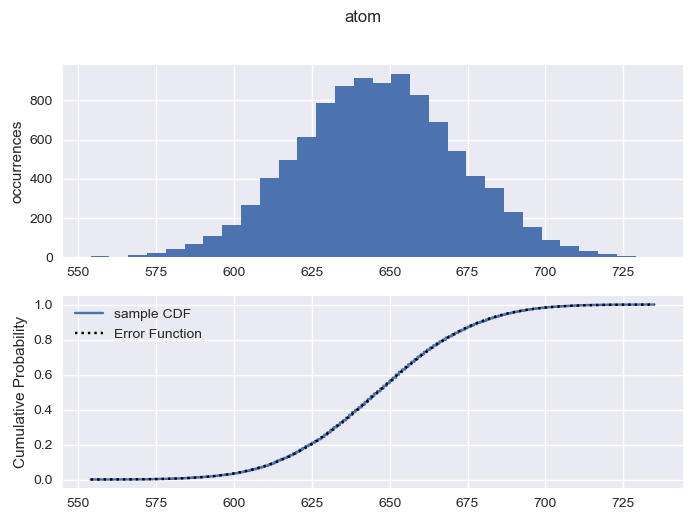

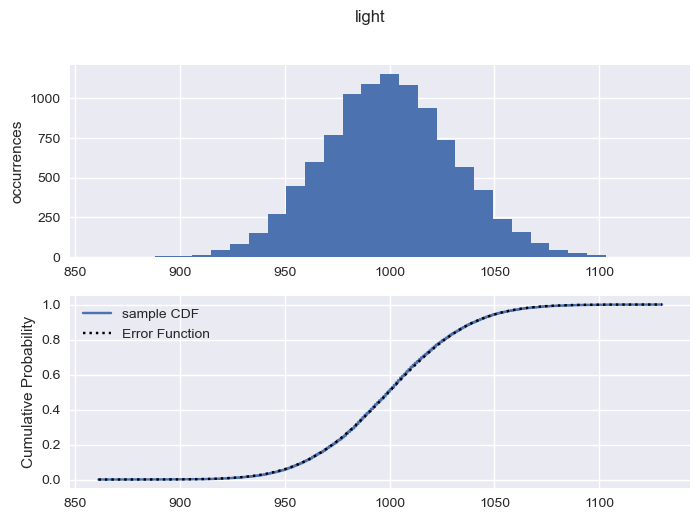

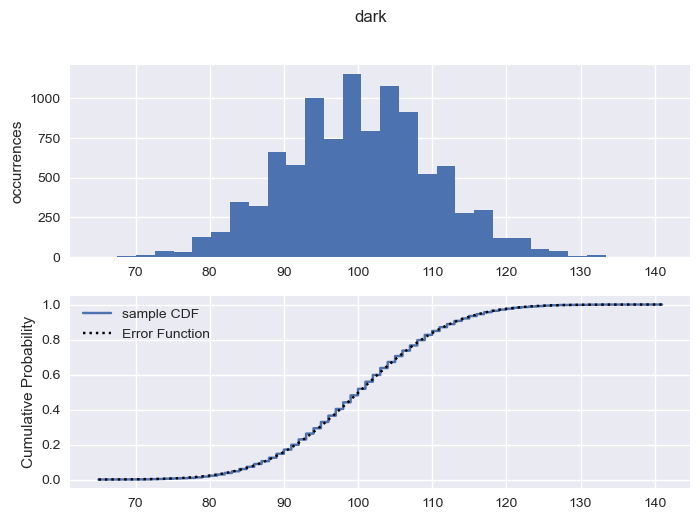

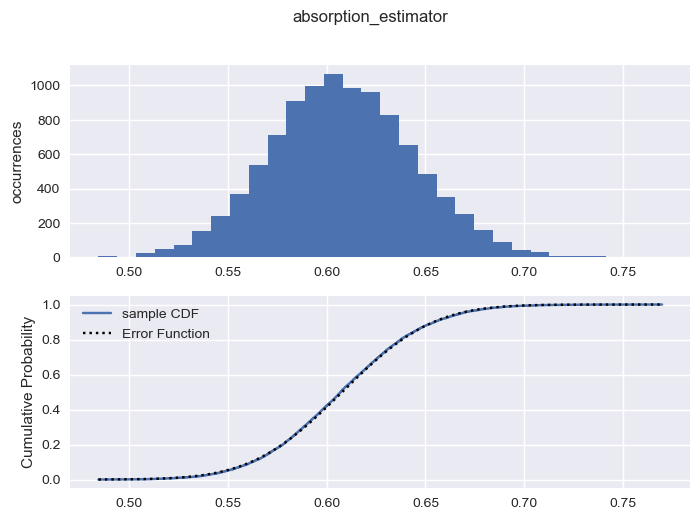

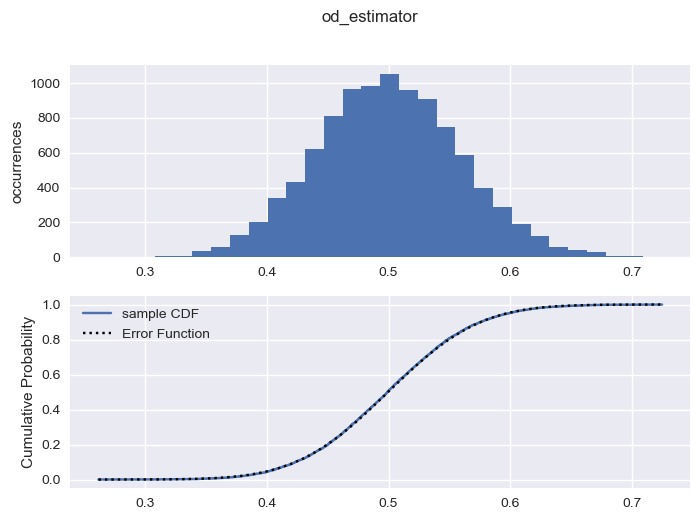

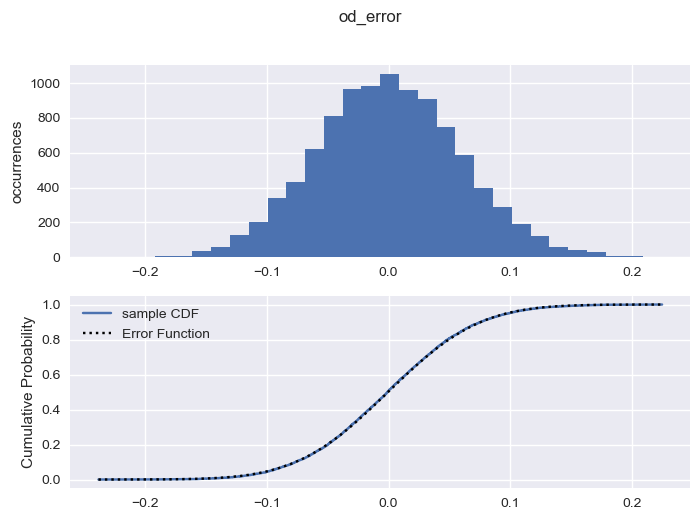

mean_light_count: 900, mean_dark_count: 100, od: 1.3


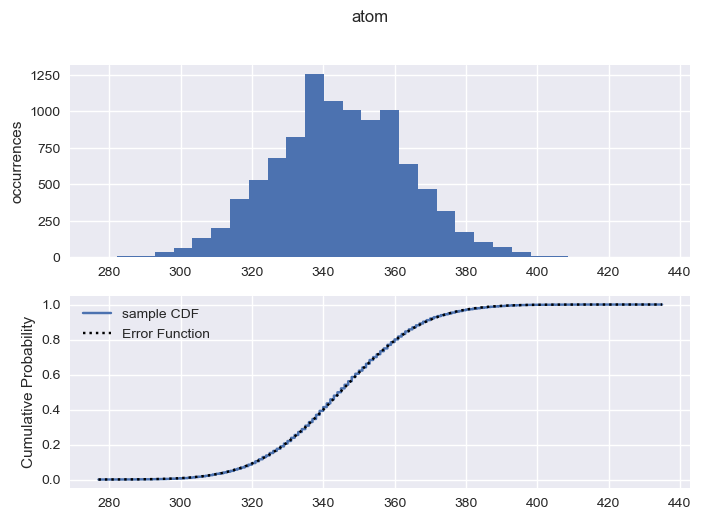

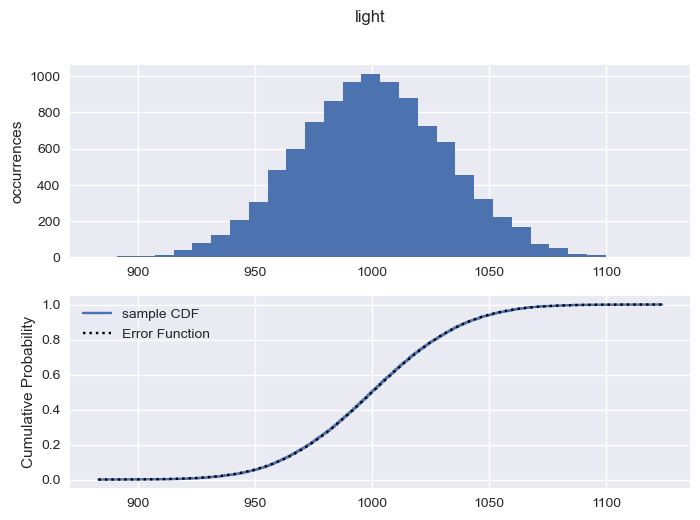

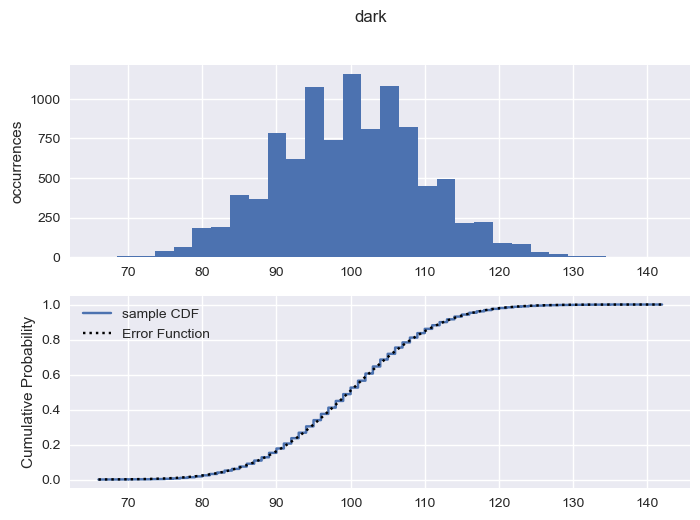

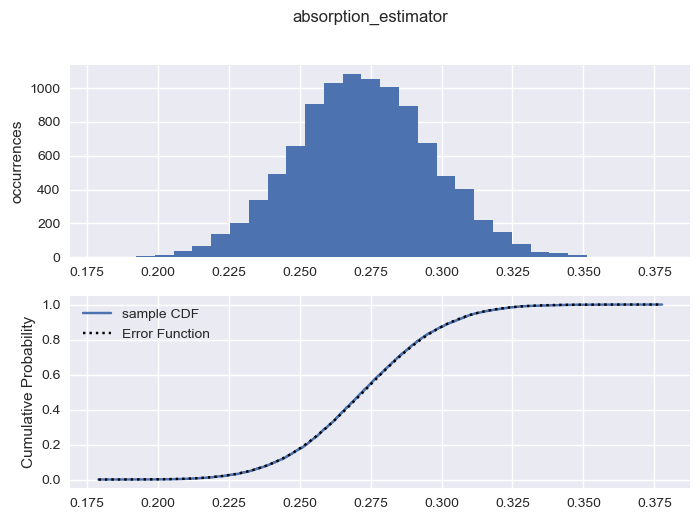

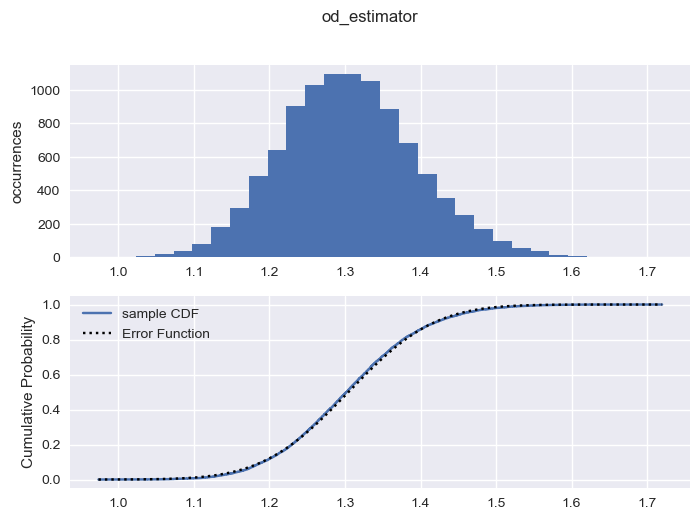

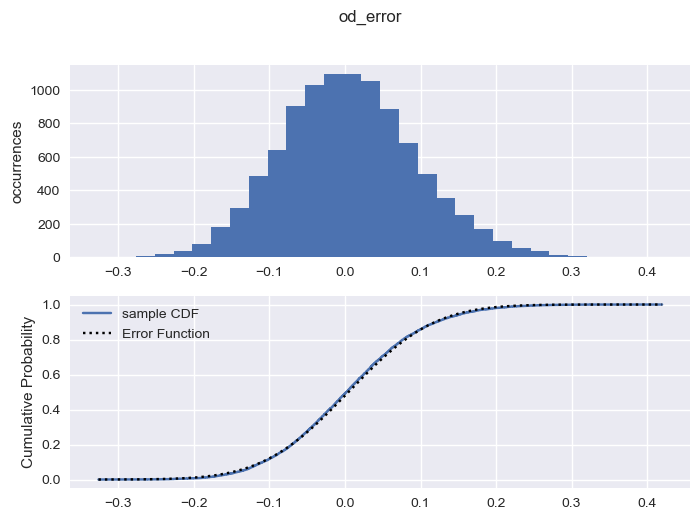

In [87]:
LAMBDA_L, LAMBDA_D, OD, N_SAMPLES = 900, 100, 0.5, 10000
print(f"mean_light_count: {LAMBDA_L}, mean_dark_count: {LAMBDA_D}, od: {OD}")
cdf_and_hist_demo(LAMBDA_L, LAMBDA_D, OD, N_SAMPLES)

LAMBDA_L, LAMBDA_D, OD, N_SAMPLES = 900, 100, 1.3, 10000
print(f"mean_light_count: {LAMBDA_L}, mean_dark_count: {LAMBDA_D}, od: {OD}")
cdf_and_hist_demo(LAMBDA_L, LAMBDA_D, OD, N_SAMPLES)

# Typical unbinned experimental parameters on a cycling transition

TODO: understand if data actually follows a Poisson distribution or if EM gain adds a static multiplier.

Observations:
- noise is the dominant source of error, not bias.
- the bias is positive, i.e. optical densities are overestimated. This makes sense given the concavity of the logarithm function.

C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3989990882.py:22: RuntimeWarning: divide by zero encountered in log
  samples_od_estimator = -np.log(samples_absorption_estimator)
C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3989990882.py:21: RuntimeWarning: divide by zero encountered in true_divide
  samples_absorption_estimator = (samples_A - samples_D) / (samples_L - samples_D)
C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3989990882.py:22: RuntimeWarning: invalid value encountered in log
  samples_od_estimator = -np.log(samples_absorption_estimator)
C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3989990882.py:21: RuntimeWarning: invalid value encountered in true_divide
  samples_absorption_estimator = (samples_A - samples_D) / (samples_L - samples_D)


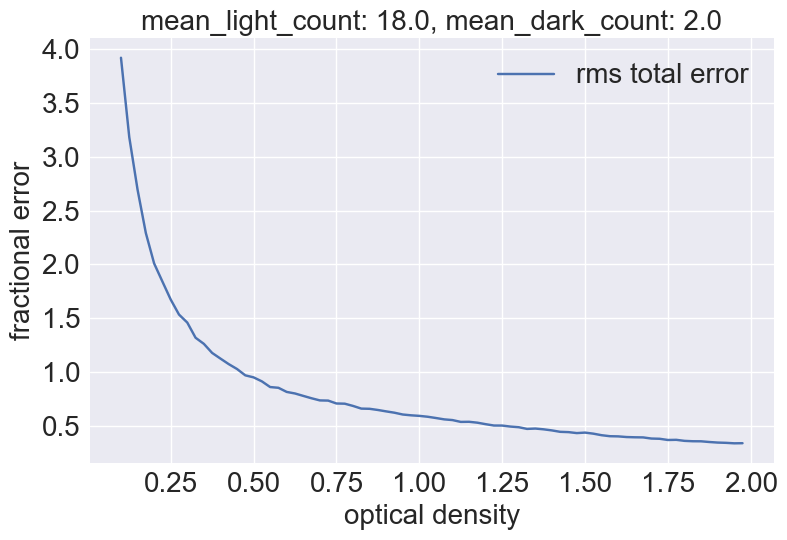

In [79]:
def plot_error_vs_od(od_arr, mean_light_count, mean_dark_count, n_samples, **kwargs):
    """
    
    """
    total_err_arr, bias_arr, var_arr = [], [], []
    for od in od_arr:
        my_samples_dict = generate_samples(mean_light_count, mean_dark_count, od, n_samples)
        my_bias_var_dict = get_bias_variance(my_samples_dict["od_error"], **kwargs)
        bias_arr.append(my_bias_var_dict["bias"]), var_arr.append(my_bias_var_dict["variance"]), total_err_arr.append(my_bias_var_dict["rms_total"])

    total_err_arr, bias_arr, var_arr = (np.array(arr) for arr in (total_err_arr, bias_arr, var_arr))

    plt.style.use("seaborn")
    plt.title(f"mean_light_count: {mean_light_count}, mean_dark_count: {mean_dark_count}", fontsize=20)
    plt.plot(od_arr, total_err_arr / od_arr, label="rms total error")
    # plt.plot(od_arr, bias_arr / od_arr, label="bias")
    # plt.plot(od_arr, var_arr**0.5 / od_arr, label="stdev")
    plt.xlabel("optical density", fontsize=20)
    plt.ylabel("fractional error", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20)
    plt.tight_layout()
    # plt.show()

od_arr = np.arange(0.1, 2, 0.025)
LAMBDA_L, LAMBDA_D, N_SAMPLES = 900/50, 100/50, 10000
plot_error_vs_od(od_arr, LAMBDA_L, LAMBDA_D, N_SAMPLES)

With binning, we multiply the light counts by the bin size. Let's try 2x, 4x, 6x, and 8x binning.

C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3989990882.py:21: RuntimeWarning: divide by zero encountered in true_divide
  samples_absorption_estimator = (samples_A - samples_D) / (samples_L - samples_D)
C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3989990882.py:22: RuntimeWarning: divide by zero encountered in log
  samples_od_estimator = -np.log(samples_absorption_estimator)
C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3989990882.py:22: RuntimeWarning: invalid value encountered in log
  samples_od_estimator = -np.log(samples_absorption_estimator)
C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3989990882.py:22: RuntimeWarning: invalid value encountered in log
  samples_od_estimator = -np.log(samples_absorption_estimator)
C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3989990882.py:22: RuntimeWarning: divide by zero encountered in log
  samples_od_estimator = -np.log(samples_absorption_estimator)
C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3989990882.py:22: R

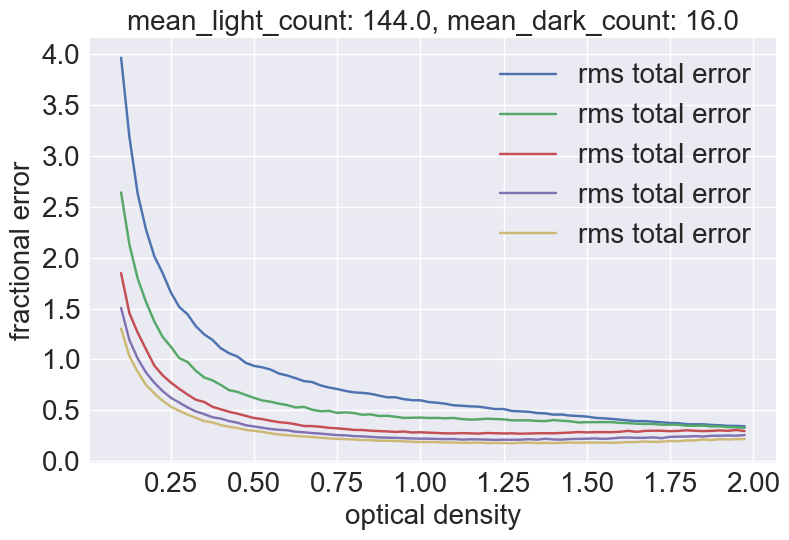

In [80]:
for bin_factor in np.concatenate([[1], np.arange(2, 10, 2)]):
    od_arr = np.arange(0.1, 2, 0.025)
    LAMBDA_L, LAMBDA_D, N_SAMPLES = 900/50 * bin_factor, 100/50 * bin_factor, 10000
    plot_error_vs_od(od_arr, LAMBDA_L, LAMBDA_D, N_SAMPLES)

Now we see what happens when the signal light intensity is close to the background intensity, as it is for non-cycling transitions.

Here we run into problems where the naive estimator for the absorption fraction sometimes becomes < 0, which I have currently just discarded from the sample. 

We see that the systematic bias becomes more pronounced. This can be attributed more samples where the absorption fraction is close to 0 and gives +inf.

C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3577936849.py:22: RuntimeWarning: invalid value encountered in log
  samples_od_estimator = -np.log(samples_absorption_estimator)
C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3577936849.py:22: RuntimeWarning: divide by zero encountered in log
  samples_od_estimator = -np.log(samples_absorption_estimator)


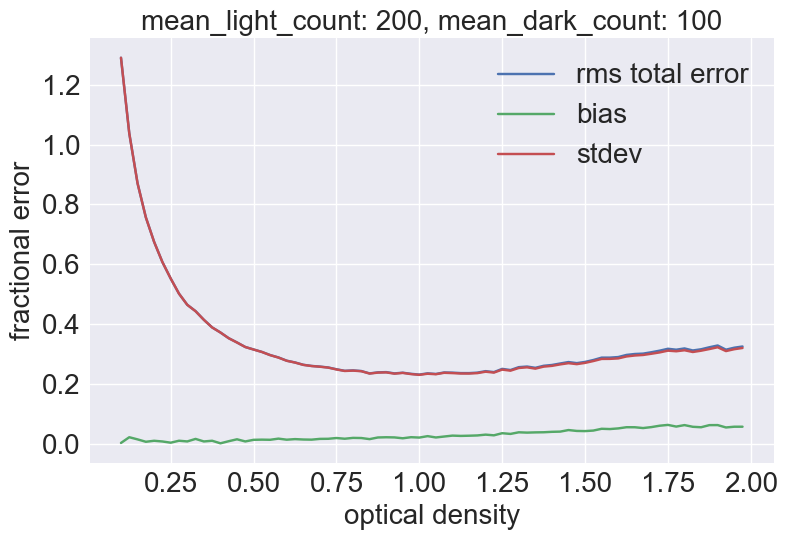

C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3577936849.py:22: RuntimeWarning: invalid value encountered in log
  samples_od_estimator = -np.log(samples_absorption_estimator)
C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3577936849.py:22: RuntimeWarning: divide by zero encountered in log
  samples_od_estimator = -np.log(samples_absorption_estimator)


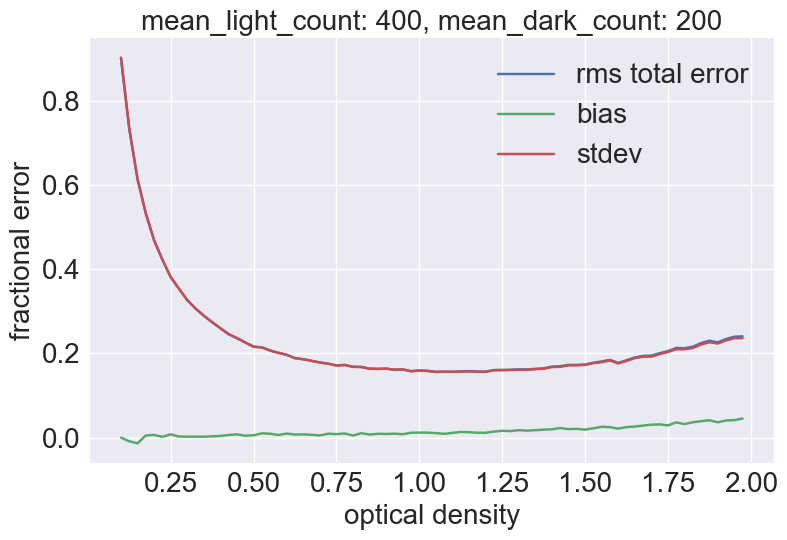

C:\Users\alexc\AppData\Local\Temp\ipykernel_14360\3577936849.py:22: RuntimeWarning: invalid value encountered in log
  samples_od_estimator = -np.log(samples_absorption_estimator)


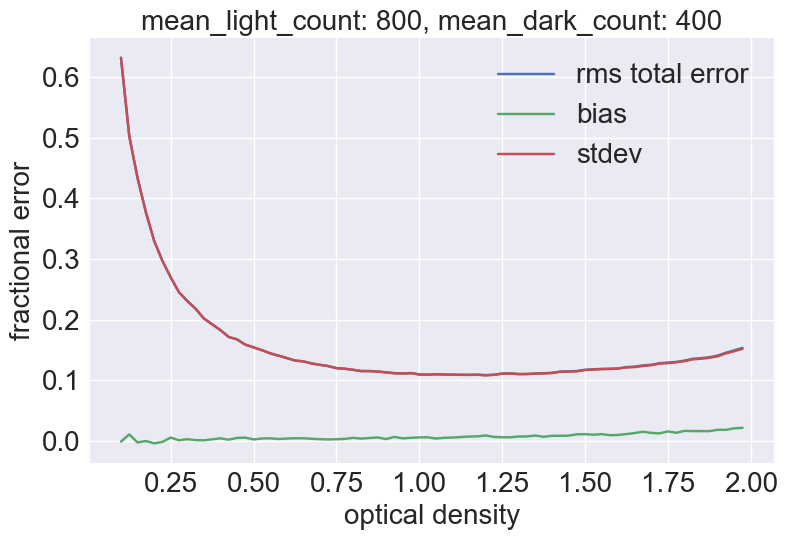

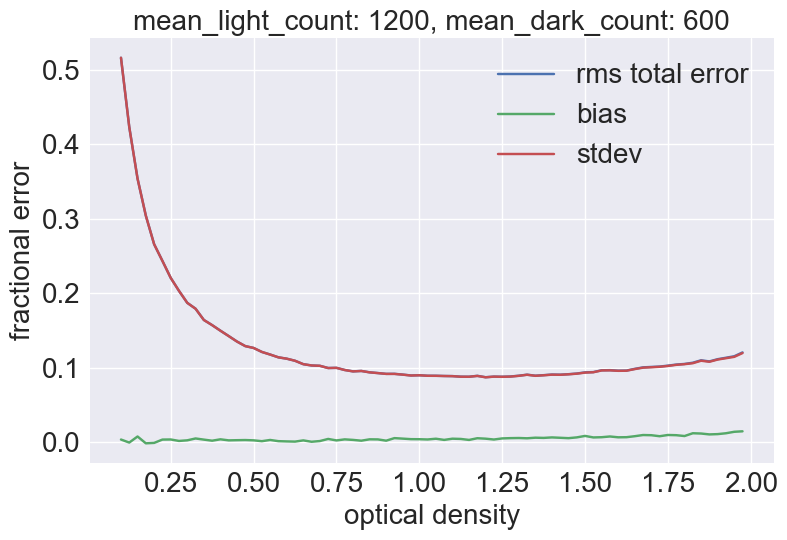

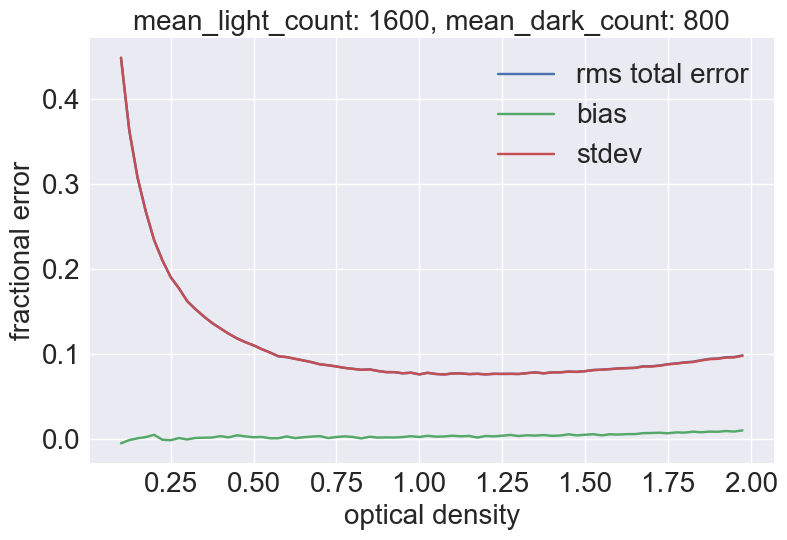

In [61]:
for bin_factor in np.concatenate([[1], np.arange(2, 10, 2)]):
    od_arr = np.arange(0.1, 2, 0.025)
    LAMBDA_L, LAMBDA_D, N_SAMPLES = 200 * bin_factor, 100 * bin_factor, 10000
    plot_error_vs_od(od_arr, LAMBDA_L, LAMBDA_D, N_SAMPLES)